## Machine Learning for Neuroscience, <br>Department of Brain Sciences, Faculty of Medicine, <br> Imperial College London
### Contributors: Francesca Palermo, Nan Fletcher-Lloyd, Alex Capstick, Yu Chen
**Winter 2022**

# Convolutional Neural Network (ConvNet/CNN)

Convolutional Neural Networks (ConvNet/CNN) are Deep Learning models that can take an input image, assign relevance (learnable weights and biases) to various aspects/objects in the image, and distinguish between them. <br />



<center><img src="./_dependents/rgb.png?raw=true" width="500" /></center>

You often see images divided into three colour planes — Red, Green, and Blue — RGB. <br />
But they can be stored in a variety of colour spaces, including Grayscale, RGB, HSV, CMYK, and others. <br />


With the basic machine learning techniques, it is required to hand-engineering features and analyse the figures dimension by dimension. 
Imagine now taking a photo which exceeds 8K (7680x4320) dimensions and how computationally intensive it will be.
The ConvNet's job is to compress the images into a format that is easier to process while preserving elements that are important for obtaining a decent prediction. This is critical for designing an architecture that is capable of learning features while also being scalable to large datasets. <br />
So, while basic machine learning techniques require hand-engineering of features, ConvNets can learn these filters/characteristics through training.


Below an example of a CNN architecture for classification. Starting from a picture, it analyses through its layers and output the correct class of object present in the image (a car in this case)

<center><img src="./_dependents/basic_architecture.png?raw=true" width="800" /></center>


## Using PyTorch for creating a CNN architecture

In this experiment we will use the ```PyTorch``` library for creating our own CNN model.

First of all, let us import the necessary libraries with the following commands:

In [1]:
import torch # PyTorch is an open source machine learning framework.
import torchvision # The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.
from torchvision import transforms
from PIL import Image # PIL is a library to process images
import numpy as np # package to work with numbers
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
import os
import glob
from pandas.core.common import flatten
import random
from collections import Counter
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

d:\Anaconda3\envs\imperial\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can create a ```device``` variable to check if a GPU is available.
If the output of device variable is 'cuda', then it means that PyTorch will use a GPU for the analysis. Otherwise, CPU is used instead.

In [2]:
# Device configuration
print('GPU available: {}' .format(torch.cuda.is_available())) 
print(torch.cuda.get_device_name(0)) # print the name of the gpu, if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_on_gpu = torch.cuda.is_available()
device


GPU available: True
NVIDIA GeForce RTX 3070


device(type='cuda')

## Load MRI Image Dataset

We will now load the  ```Alzheimer MRI Preprocessed Dataset``` dataset that we will use for the laboratory. For easier access, the dataset has already been downloaded and need to be unzip in a folder of your choice which will be called the ```dataset_path```. This dataset is made of around 6400 images of 128 x 128 pixels. For our analysis we have split the dataset into two classes: Dementia and Healthy.


Additional information on the dataset can be found [here](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset)

We need to first unzip the archive file.

In [3]:
import shutil
shutil.unpack_archive('./database/MRI_database.zip', './database/') # specificy the file to unpack and where to unpack it

We can then start load the data and creating the training, testing and validation datasets

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

image_paths = [] #to store image paths in list
classes = [] #to store class values
dataset_path = './database/'
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.jpg'):
            classes.append(subdir.split('/')[-1].split('\\')[-1]) 
            image_paths.append(os.path.join(subdir, file))
    
image_paths = list(flatten(image_paths))

print('classes: {}'.format(np.unique(classes))) 
print(Counter(classes))
print("Original dataset size: {}".format(len(image_paths)))

# train 70% validation 20% test 10%
X_train, X_test, y_train, y_test = train_test_split(image_paths, classes, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
n_classes = len(np.unique(y_train))

print('\nSplit datasets size:\nTrain-set {} {}\nValidation-set {} {}\nTest-set {} {}'.format(len(X_train), Counter(y_train), len(X_val), Counter(y_val), len(X_test), Counter(y_test),))


classes: ['Dementia' 'Healthy']
Counter({'Dementia': 3200, 'Healthy': 3200})
Original dataset size: 6400

Split datasets size:
Train-set 4608 Counter({'Healthy': 2311, 'Dementia': 2297})
Validation-set 1152 Counter({'Healthy': 590, 'Dementia': 562})
Test-set 640 Counter({'Dementia': 341, 'Healthy': 299})


Since the labels are categorically encoded, we can create a dictionary to associate each label to a different integer.

In [5]:
idx_to_class = {i:j for i, j in enumerate(np.unique(classes))}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx


{'Dementia': 0, 'Healthy': 1}

## Preparing data with DataLoader

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting.

```DataLoader``` is an iterable variable that we can use in PyTorch to automatically perform these functions.

For additional information on ```DataLoader```, you can refer to the [official documentation](https://pytorch.org/docs/stable/data.html)

To load the dataset into pytorch, we need to create a class which will be able to correctly load each image in the correct set.

In [6]:
class MRIDataset(Dataset):
    def __init__(self, image_paths, classes, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        label = self.classes[idx]
        label = class_to_idx[label]
        # label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

We can then create the training, validation and testing sets.

In [7]:
train_dataset = MRIDataset(X_train, y_train, transform)
val_dataset = MRIDataset(X_val, y_val, transform)
test_dataset = MRIDataset(X_test, y_test, transform)

Below we will load the dataset into DataLoader of batch_size=64 features and labels respectively. 

In [8]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We can iterate over the DataLoader variable and extracting the features of the image and the corresponding label

(3, 128, 128)

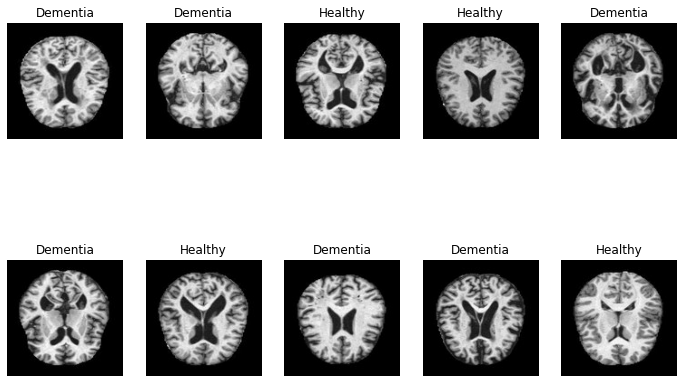

In [9]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    # plt.imshow()  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
ncols = 5
nrows = 2
figure, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
for i in range(nrows*ncols):
    ax.ravel()[i].imshow((np.transpose(images[i], (1, 2, 0))* 255).astype(np.uint8))
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(idx_to_class[labels[i].item()])
images[i].shape

## Create CNN Architecture

We will now create the architecture for the CNN. In this example we will use two convolutional layers followed by three fully-connected layers. 

When creating the network, we also need to specify the activation function of each layer. We will use the Rectified Linear Units (ReLU) in this case.

If necessary, we can also introduce a regularisation layer to reduce possible overfitting. A simple way to do this can be to use dropout layers.


In [10]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# define the CNN architecture

class CNN(nn.Module):
    def __init__(self, n_class):
        super(CNN, self).__init__()
               
        self.conv1 = nn.Conv2d(3, 16, 3) #n_channels = 3, rgb image. These parameters can be modified and optimised based on the task and/or dataset
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2) # Applies 2D max-pooling to reduce the spatial dimensions of the input volume
        self.conv2 = nn.Conv2d(16, 32, 3)  
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(0.2)
        self.conv3 = nn.Conv2d(32, 64, 3)  
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(12544, 128) # Fully connected layers
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, n_class)
        self.flatten = nn.Flatten()
    
    
    # The forward pass defines the way we compute the output using the given layers and functions.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # activation function
        x = self.batchnorm1(x)
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.batchnorm2(x)
        x = self.conv2_drop(x)
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.batchnorm3(x)
        x = self.conv3_drop(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# create the model CNN
model = CNN(n_classes)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.to(device=device)

We can print the architecture of the CNN network to investigate its layers

In [11]:
from torchsummary import summary

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
         MaxPool2d-2           [-1, 16, 63, 63]               0
       BatchNorm2d-3           [-1, 16, 63, 63]              32
            Conv2d-4           [-1, 32, 61, 61]           4,640
         MaxPool2d-5           [-1, 32, 30, 30]               0
       BatchNorm2d-6           [-1, 32, 30, 30]              64
         Dropout2d-7           [-1, 32, 30, 30]               0
            Conv2d-8           [-1, 64, 28, 28]          18,496
         MaxPool2d-9           [-1, 64, 14, 14]               0
      BatchNorm2d-10           [-1, 64, 14, 14]             128
        Dropout2d-11           [-1, 64, 14, 14]               0
          Flatten-12                [-1, 12544]               0
           Linear-13                  [-1, 128]       1,605,760
           Linear-14                   

## Define Loss and Optimser 

**Loss**

Deep neural network are trained via an algorithm called stochastic gradient descent optimization.
It is necessary to repeatedly estimate the error for the model's current state as part of the optimiaation method. In order to update the weights and lower the loss on the subsequent evaluation, it is necessary to select an error function, also known as a loss function, that may be used to estimate the loss of the model.

There exist multiple and different losses based on the scope of the analysis.
In this experiment, we are interested in classifying the number present in the image. We are then performing a multi-class classification. Our goal is to predict the probability of the sample belonging to each known class (from number 0 to 9).

We can then use a loss called ```Cross-entropy```. It will calculate a score to summarise the average difference between the actual and predicted probability distributions for all classes. To achieve the best results we have to minimise this loss



**Optimiser**

When training the model, we need to minimise the loss function and update the weights of the model at each epoch. 
In other words, we need to optimise the neural network.
An optimiser is a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. It works for reducing the loss and improve the overall accuracy.

There are various types of optimiser. In our case, we will use ```Adam``` which is one of the most popular gradient descent optimisation algorithms.

When setting up the optimiser, we also need to decide at which speed the model will learn. This is done via the learning rate.
It will tell the model how fast or slow we will move towards the optimal weights
<center><img src="./_dependents/learning_rate.png" width="300" /></center>

In [12]:
criterion = torch.nn.CrossEntropyLoss().to(device)  # cross-entropy loss for classification
optimiser = torch.optim.Adam(model.parameters(), lr=0.001) 

optimiser

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

## Train the model

We have finally set up all the parameters and we can move on to train the model on our dataset.
We need to set the number of iterations that we want to train our model. This number needs to be carefully decided: if it is too low, then we risk of underfitting our model, if it is too high, we risk of overfitting it.
<center><img src="./_dependents/overfitting_model.png" width="300" /></center>

[INFO] TRAINING EPOCH 1
[INFO] Epoch 1, Training Loss: 0.594679
[INFO] VALIDATION EPOCH 1
[INFO] Epoch 1, Validation Loss: 0.566541
Validation loss decreased (inf --> 0.566541).  Saving model ...
-----------------------------------------------------------
[INFO] TRAINING EPOCH 2
[INFO] Epoch 2, Training Loss: 0.470033
[INFO] VALIDATION EPOCH 2
[INFO] Epoch 2, Validation Loss: 0.404361
Validation loss decreased (0.566541 --> 0.404361).  Saving model ...
-----------------------------------------------------------
[INFO] TRAINING EPOCH 3
[INFO] Epoch 3, Training Loss: 0.351587
[INFO] VALIDATION EPOCH 3
[INFO] Epoch 3, Validation Loss: 0.293041
Validation loss decreased (0.404361 --> 0.293041).  Saving model ...
-----------------------------------------------------------
[INFO] TRAINING EPOCH 4
[INFO] Epoch 4, Training Loss: 0.219788
[INFO] VALIDATION EPOCH 4
[INFO] Epoch 4, Validation Loss: 0.415056
-----------------------------------------------------------
[INFO] TRAINING EPOCH 5
[INFO]

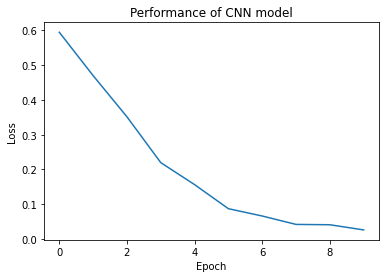

In [13]:
model = CNN(n_classes)
if train_on_gpu:
    model.to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)  # cross-entropy loss for classification
optimiser = torch.optim.Adam(model.parameters(), lr=0.001) 

# number of epochs to train the model
n_epochs = 10

#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    print('[INFO] TRAINING EPOCH {}'.format(epoch))
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.to(device=device), target.to(device=device)
        # clear the gradients of all optimized variables
        optimiser.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimiser.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    train_losslist.append(train_loss)
    print('[INFO] Epoch {}, Training Loss: {:.6f}'.format(epoch, train_loss))
        
    ######################    
    # validate the model #
    ######################
    print('[INFO] VALIDATION EPOCH {}'.format(epoch))
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.to(device=device), target.to(device=device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    valid_loss = valid_loss/len(valid_loader.dataset)
    print('[INFO] Epoch {}, Validation Loss: {:.6f}'.format(epoch, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_MRI.pt')
        valid_loss_min = valid_loss
    print('-----------------------------------------------------------')    

plt.plot([*range(n_epochs)], train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of CNN model")
plt.show()


## Test the model

We will now load the model which achieved the best results during training and we will test it on the testing set

In [14]:
model.load_state_dict(torch.load('model_MRI.pt'))

<All keys matched successfully>

In [15]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

total_test_predicted_labels = []
total_test_true_labels = []

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.to(device=device), target.to(device=device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    total_test_true_labels.append(target.cpu().numpy())
    total_test_predicted_labels.append(pred.cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(target.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
        
y_true = np.asarray([item for sublist in total_test_true_labels for item
                             in sublist])
y_pred = np.asarray([item for sublist in total_test_predicted_labels for
                               item in sublist])        

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            np.unique(classes)[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.095937

Test Accuracy of Dementia: 95% (326/341)
Test Accuracy of Healthy: 98% (294/299)

Test Accuracy (Overall): 96% (620/640)


## Investigate results

In [16]:
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
cf = confusion_matrix(y_true, y_pred)
print('ACCURACY: {:.2f}\n RECALL: {:.2f}\n PRECISION: {:.2f}\n F1: {:.2f}\n  '.format(accuracy, 
                                                                                      recall,
                                                                                      precision, 
                                                                                      f1))
print(cf)

ACCURACY: 0.97
 RECALL: 0.97
 PRECISION: 0.97
 F1: 0.97
  
[[326  15]
 [  5 294]]


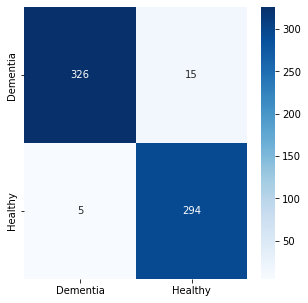

In [17]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cf, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xticklabels(np.unique(classes))
ax.set_yticklabels(np.unique(classes))
plt.show()

## Create Train and Test Methods 

We can further analyse the model by changing various values in the architecture of the network. 
Instead of having training and testing in the script, we can create two functions which will be called whenever we need to train or test the model. We can load the train and test methods from Lecture 6 - Neural Networks.

In [18]:
from utils import module_from_file
train_model = module_from_file(
    "model_trainer",
    "../../Topic-06- Neural Networks/Lab/model_trainer.py"
    ).train

predict_model = module_from_file(
    "model_predictor",
    "../../Topic-06- Neural Networks/Lab/model_predictor.py"
    ).predict

After importing the methods, we can start the training of the model by passing the train and val loader, the number of epochs, the optimiser and criterion.

In [19]:
model = CNN(n_classes)
if train_on_gpu:
    model.to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)  # cross-entropy loss for classification
optimiser = torch.optim.Adam(model.parameters(), lr=0.001) 


model, (train_loss_dict, val_loss_dict) = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    )
# torch.save(model.state_dict(), 'model_MRI.pt') # if you want to save the model, you can change the name as you prefer

Training: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it, Train Loss=0.025, Val Loss=0.200]


Once the training is finished, we can then test the model on the test dataset and predict the possible labels. 

In [20]:
y_pred, y_true = predict_model(model, test_loader=test_loader)
# finding the class of max probability
_, y_pred = torch.max(y_pred, dim=1) 
y_pred = y_pred.numpy()
y_true = y_true.numpy()
print(y_pred[0:5])
print(y_true[0:5])

Predicting: 100%|██████████| 10/10 [00:00<00:00, 16.30it/s]


[0 0 1 1 0]
[0 0 1 1 0]


We can then investigate the results as done in the previous section

In [21]:
# simple methods to calculate all the required metrics for analysing the model. You can also return the metrics, if you want to further analyse them
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cf = confusion_matrix(y_true, y_pred)
    print('ACCURACY: {:.2f}\n RECALL: {:.2f}\n PRECISION: {:.2f}\n F1: {:.2f}\n  '.format(accuracy, 
                                                                                        recall,
                                                                                        precision, 
                                                                                        f1))
    print(cf)
    return accuracy, recall, precision, f1, cf

In [22]:
original_accuracy, original_recall, original_precision, original_f1, original_cf = calculate_metrics(y_true, y_pred)

ACCURACY: 0.94
 RECALL: 0.94
 PRECISION: 0.95
 F1: 0.94
  
[[303  38]
 [  0 299]]


## Additional Questions

### 1) We have introduced a CNN model and two methods for training and making predictions on a dataset. We can now investigate what would happen when using the same CNN model as before but changing the learning rate in the optimiser. Try training with different learning rates and investigate if there are any changes.

In [23]:
n_epochs = 10 

model = CNN(n_classes)

criterion = torch.nn.CrossEntropyLoss().to(device)  # cross-entropy loss for classification
optimiser = torch.optim.Adam(model.parameters(), lr=0.1) 

model, (lr_train_loss_dict, lr_val_loss_dict) = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    )
    
y_pred, y_true = predict_model(model, test_loader=test_loader)
# finding the class of max probability
_, y_pred = torch.max(y_pred, dim=1) 
y_pred = y_pred.numpy()
y_true = y_true.numpy()
lr_accuracy, lr_recall, lr_precision, lr_f1, lr_cf = calculate_metrics(y_true, y_pred)

Predicting: 100%|██████████| 10/10 [00:00<00:00, 26.43it/s]

ACCURACY: 0.53
 RECALL: 0.53
 PRECISION: 0.28
 F1: 0.37
  
[[341   0]
 [299   0]]



d:\Anaconda3\envs\imperial\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Performance of CNN model')

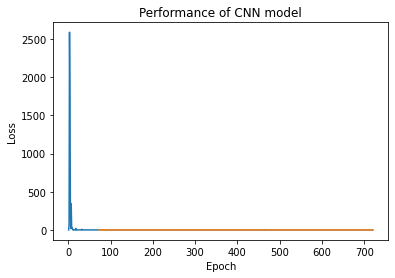

In [24]:
fig, ax = plt.subplots()
# plot training loss
ax.plot(
    lr_train_loss_dict['step'], lr_train_loss_dict['loss'],
    label='Train'
    )

# plot training loss
ax.plot(
    lr_val_loss_dict['step'], lr_val_loss_dict['loss'],
    label='Val'
    )
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Performance of CNN model")

### 2) Let us investigate now what would happen when changing the type of optimiser used for the classification. We can change the optimiser based on our need and task. <br>
More information can be found: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [25]:
n_epochs = 10 

model = CNN(n_classes)

criterion = torch.nn.CrossEntropyLoss().to(device)  # cross-entropy loss for classification
optimiser = torch.optim.SGD(model.parameters(), lr=0.001)

model, (opt_train_loss_dict, opt_val_loss_dict) = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    )
    
y_pred, y_true = predict_model(model, test_loader=test_loader)
# finding the class of max probability
_, y_pred = torch.max(y_pred, dim=1) 
y_pred = y_pred.numpy()
y_true = y_true.numpy()
opt_accuracy, opt_recall, opt_precision, opt_f1, opt_cf = calculate_metrics(y_true, y_pred)

Predicting: 100%|██████████| 10/10 [00:00<00:00, 25.60it/s]

ACCURACY: 0.75
 RECALL: 0.75
 PRECISION: 0.76
 F1: 0.75
  
[[245  96]
 [ 61 238]]


Text(0.5, 1.0, 'Performance of CNN model')

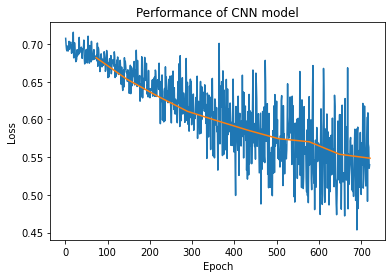

In [26]:
fig, ax = plt.subplots()
# plot training loss
ax.plot(
    opt_train_loss_dict['step'], opt_train_loss_dict['loss'],
    label='Train'
    )

# plot training loss
ax.plot(
    opt_val_loss_dict['step'], opt_val_loss_dict['loss'],
    label='Val'
    )
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Performance of CNN model")

### 3) We can also change the number of epochs and check how the model learns depending on this parameter.

In [28]:
n_epochs = 50

model = CNN(n_classes)

criterion = torch.nn.CrossEntropyLoss().to(device)  # cross-entropy loss for classification
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001) 

model, (epcs_train_loss_dict, epcs_val_loss_dict) = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    )
    
y_pred, y_true = predict_model(model, test_loader=test_loader)
# finding the class of max probability
_, y_pred = torch.max(y_pred, dim=1) 
y_pred = y_pred.numpy()
y_true = y_true.numpy()
epcs_accuracy, epcs_recall, epcs_precision, epcs_f1, epcs_cf = calculate_metrics(y_true, y_pred)

Predicting: 100%|██████████| 10/10 [00:00<00:00, 28.37it/s]

ACCURACY: 0.99
 RECALL: 0.99
 PRECISION: 0.99
 F1: 0.99
  
[[339   2]
 [  4 295]]


Text(0.5, 1.0, 'Performance of CNN model')

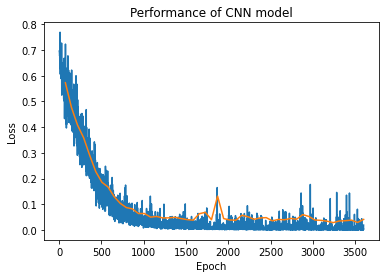

In [29]:
fig, ax = plt.subplots()
# plot training loss
ax.plot(
    epcs_train_loss_dict['step'], epcs_train_loss_dict['loss'],
    label='Train'
    )

# plot training loss
ax.plot(
    epcs_val_loss_dict['step'], epcs_val_loss_dict['loss'],
    label='Val'
    )
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Performance of CNN model")


### 4) Let's plot the above losses all together and compare them with the original loss

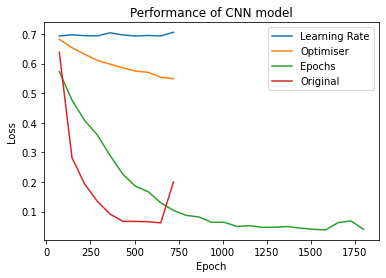

In [30]:
fig, ax = plt.subplots()
ax.plot(
    lr_val_loss_dict['step'], lr_val_loss_dict['loss'],
    label='Learning Rate'
    )

ax.plot(
    opt_val_loss_dict['step'], opt_val_loss_dict['loss'],
    label='Optimiser'
    )

ax.plot(
    epcs_val_loss_dict['step'][0:25], epcs_val_loss_dict['loss'][0:25],
    label='Epochs'
    )

ax.plot(
    val_loss_dict['step'], val_loss_dict['loss'],
    label='Original'
    )


ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Performance of CNN model")
plt.legend()

## Additional Resources

- Documentation for the Convolutional Layer - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html 
- Guide and discussion on optimisers - https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0
- CIFAR10 Tutorial - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- CNN implementation on CIFAR10 - https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844